In [ ]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model,Sequential
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
from keras.callbacks import EarlyStopping,ModelCheckpoint
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Model,load_model
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
InputPath='/content/drive/MyDrive/heritage/Akhijhyal/'

Mounted at /content/drive


In [ ]:
input_shape=(512,512,3)

model = Sequential()
# encoder network
model.add(Conv2D(128, 3, activation= 'relu', padding='same', input_shape = input_shape))
model.add(MaxPooling2D(2, padding= 'same'))

model.add(Conv2D(64, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))

model.add(Conv2D(32, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))

model.add(Conv2D(64, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))

model.add(Conv2D(32, 3, activation= 'relu', padding='same'))
model.add(MaxPooling2D(2, padding= 'same'))

#decoder network

model.add(Conv2D(32, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))

model.add(Conv2D(64, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))

model.add(Conv2D(32, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))

model.add(Conv2D(64, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))

model.add(Conv2D(128, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))

model.add(Conv2D(3,3,activation='sigmoid', padding= 'same')) # output layer
model.compile(optimizer= 'adam', loss = 'mse',metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_103 (Conv2D)         (None, 512, 512, 128)     3584      
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 256, 256, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 256, 256, 64)      73792     
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 64, 64, 32)       

In [ ]:
def ExtractDataPath(InputPath):
    TargetImg = os.path.join(InputPath+'Akhijhyal')
    SourceImg = os.path.join(InputPath+'Heritage_data')
    X_=[]
    y_=[]
    for path_T in os.listdir(TargetImg):
      Target_path=os.path.join(TargetImg,path_T)
      img_2_path = Target_path
      for path_S in os.listdir(os.path.join(SourceImg,path_T)):
        y_.append(img_2_path)
        source_img=os.path.join(SourceImg,path_T,path_S)
        img_1_path = source_img
        X_.append(img_1_path)

    X_ = np.array(X_)
    y_ = np.array(y_)
    return X_,y_

In [ ]:


df = pd.DataFrame()
X,Y=ExtractDataPath(InputPath)
df['Traget'] = Y
df['Source'] = X


In [ ]:
print(df)

                                                  Traget  \
0      /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
1      /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
2      /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
3      /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
4      /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
...                                                  ...   
29361  /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
29362  /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
29363  /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
29364  /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   
29365  /content/drive/MyDrive/heritage/Akhijhyal/Akhi...   

                                                  Source  
0      /content/drive/MyDrive/heritage/Akhijhyal/Heri...  
1      /content/drive/MyDrive/heritage/Akhijhyal/Heri...  
2      /content/drive/MyDrive/heritage/Akhijhyal/Heri...  
3      /content/drive/MyDrive/heritage/Akhi

In [ ]:
csv_file_path = InputPath+'/data.csv'
# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False,header=False)

In [ ]:
import pandas as pd
csv_file_path = InputPath+'/data.csv'
df = pd.read_csv(csv_file_path)

In [ ]:

df.columns = ['Image_Path', 'Target']



In [ ]:
# Shuffle the DataFrame
from sklearn.model_selection import train_test_split
df_shuffled = df.sample(frac=1, random_state=42)

# Split the shuffled data into training and validation sets
# Adjust the test_size parameter to control the size of the validation set
train_df, val_df = train_test_split(df_shuffled, test_size=0.1, random_state=42)



In [ ]:

# Set up the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
# Define a custom generator function
def custom_image_generator(dataframe, batch_size):
    num_samples = len(dataframe)
    while True:
        # Shuffle the DataFrame for each epoch
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)
        for offset in range(0, num_samples, batch_size):
            batch_df = dataframe.iloc[offset:offset + batch_size]
            batch_source_images = []
            batch_target_images = []
            for _, row in batch_df.iterrows():
                source_img = load_img(row['Image_Path'], target_size=(512, 512))
                source_img = img_to_array(source_img) / 255.0  # Normalize pixel values to [0, 1]
                target_img = load_img(row['Target'], target_size=(512, 512))
                target_img = img_to_array(target_img) / 255.0  # Normalize pixel values to [0, 1]
                batch_source_images.append(source_img)
                batch_target_images.append(target_img)
            batch_source_images = np.array(batch_source_images)
            batch_target_images = np.array(batch_target_images)
            yield batch_source_images, batch_target_images

# Example usage:
batch_size = 16
train_generator = custom_image_generator(train_df, batch_size)


In [ ]:

checkpointer = ModelCheckpoint('model_TL_UNET.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

In [ ]:
 hist=model.fit(train_generator,epochs=5,steps_per_epoch=25,callbacks=[checkpointer])

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.0505
Epoch 1: loss did not improve from 0.04361
25/25 [==============================] - 145s 6s/step - loss: 0.0505
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.0475
Epoch 2: loss did not improve from 0.04361
25/25 [==============================] - 146s 6s/step - loss: 0.0475
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.0466
Epoch 3: loss did not improve from 0.04361
25/25 [==============================] - 143s 6s/step - loss: 0.0466
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 0.0453
Epoch 4: loss did not improve from 0.04361
25/25 [==============================] - 146s 6s/step - loss: 0.0453
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 0.0457
Epoch 5: loss did not improve from 0.04361
25/25 [==============================] - 146s 6s/step - loss: 0.0457
Epoch 6/10
25/25 [==============================] - ETA: 0s - los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0445
Epoch 9: loss did not improve from 0.04315
25/25 [==============================] - 144s 6s/step - loss: 0.0445
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 0.0437
Epoch 10: loss did not improve from 0.04315
25/25 [==============================] - 147s 6s/step - loss: 0.0437


In [ ]:
#hist=model.fit(train_generator,epochs=10,steps_per_epoch=len(df) // batch_size,callbacks=[checkpointer])

KeyError: ignored

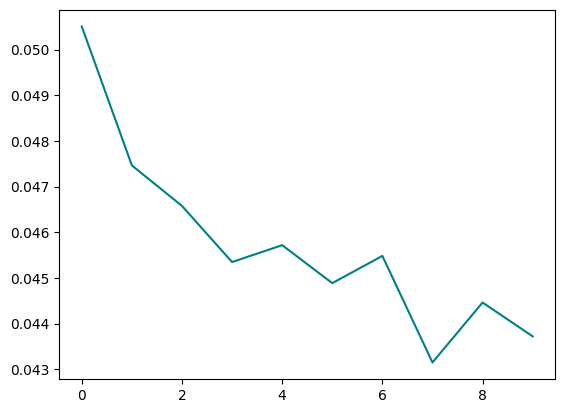

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['mae'], color='orange', label='MAE')
plt.plot(hist.history['root_mean_squared_error'], color='red', label='RMSE')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

1/1 [==============================] - 0s 359ms/step


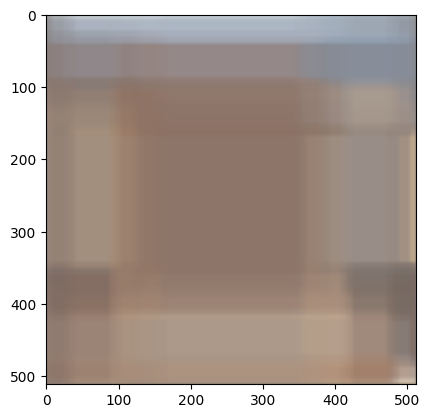

In [ ]:
from keras.models import Model,load_model
TransferLearningModel = load_model('model_TL_UNET.h5')
img_x = cv.imread(InputPath + "/2.jpg")
img_x = cv.cvtColor(img_x, cv.COLOR_BGR2RGB)
img_x = cv.resize(img_x,(512,512))
img_x=img_x/255
img_x = img_x.reshape(1,512,512,3)

prediction = model.predict(img_x)
pred = prediction.reshape(512,512,3)

pred_ = cv.resize(pred,(512,512))
plt.imshow((pred_ * 255).astype(np.uint8))